In [1]:

# from ponyge2_adapted_files import Grammar, Individual, initialisation_PI_Grow, crossover_onepoint, mutation_int_flip_per_codon
from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import div, plog, psqrt, exp
from nltk import edit_distance

from collections import Counter
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

import warnings
warnings.filterwarnings("ignore")


GRAMMAR_FILE = 'exp-grammar.bnf'

In [2]:
import contextlib, os

@contextlib.contextmanager
def set_directory(path):
    curdir= os.getcwd()
    try: 
        yield os.chdir(os.path.join(curdir, path))
    finally: os.chdir(curdir)

In [3]:
from parser import Parser, parse
from lexer import Lexer

In [4]:
parse("4*8/0")

4*8/0


In [ ]:
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

In [ ]:
import numpy as np

In [6]:
x = np.arange(0, 10)
y = lambda x: 2 * x + 1
noise = np.random.randint(0, 4, size=x.shape)
y_noised = y(x) + noise

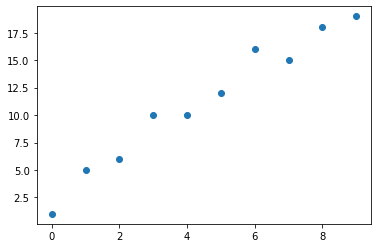

In [7]:
plt.scatter(x, y_noised)

In [9]:
def fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    if individual.invalid == True:
        return np.NaN,

    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        fitness = np.mean(np.square(y - pred))
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError, ValueError):
        fitness = np.NaN
        
    if fitness == float("inf"):
        return np.NaN,
    
    return fitness,

In [10]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)#, points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)

In [11]:
POPULATION_SIZE = 100
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 15
MAX_WRAPS = 0
CODON_SIZE = 255

In [ ]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )